# process the MPRA library fasta
- make:
    - metadata.tsv
    - tiles.bed
    - full.bed  # merged enhancers

In [1]:
LOCAL = False

from Bio.SeqIO.FastaIO import SimpleFastaParser

import matplotlib.pyplot as plt
import numpy as np
import os, sys

import pandas as pd
import pybedtools as pbt

import seaborn as sns
from scipy import stats
from sklearn.preprocessing import RobustScaler, StandardScaler

import sys

In [3]:
if LOCAL is True:
    sys.path.append("/Users/sarahfong/tools/py_")
    DATA_PATH = "/Users/sarahfong/Desktop/local_data/EMF/US"
else:
    DATA_PATH = "/wynton/group/ahituv/fongsl/projects/US/data"
import config_readwrite as crw
import plot_params as pp

pp.fonts()

('sans-serif', 'Arial', 18)

# config

In [30]:
config, cfn = crw.read(os.path.join(os.path.dirname(os.getcwd()), "config.ini"))

# make data section of config

META = config["data"]['META']
RE = config["path"]['results']

RE = os.path.join(RE, "mpra/library")

In [6]:
df = pd.read_csv(META, sep='\t')
df

,name,seq,cl.origin,exp,coor,direction,#chr_tile,start_tile,end_tile,#chr_enh,start_enh,end_enh,tile.coor,enh.coor,enh.name,tile.name,tile.order
0,bj_k27ac_down_chr3:29837526-29837795,TAAAAGTTTGTACCCCCTCCCCGTCTGTATTGAGCTGCTCATGCAT...,bj,k27ac,chr3:29837526-29837795,down,chr3,29837526.0,29837795.0,chr3,29837260.0,29838061.0,chr3:29837526-29837795,chr3:29837260-29838061,enh.7209,tile.27329,2.0
1,bj_k27ac_down_chr3:29837260-29837529,AATATTTTTAAACTCTTTATATTGTTGTTTATTACTATTTCTTAAA...,bj,k27ac,chr3:29837260-29837529,down,chr3,29837260.0,29837529.0,chr3,29837260.0,29838061.0,chr3:29837260-29837529,chr3:29837260-29838061,enh.7209,tile.27327,0.0
2,bj_k27ac_down_chr3:29837792-29838061,CCTGAGTCATTTTCTTTTAAATGATGTATTTGTGCATTCCTTCATA...,bj,k27ac,chr3:29837792-29838061,down,chr3,29837792.0,29838061.0,chr3,29837260.0,29838061.0,chr3:29837792-29838061,chr3:29837260-29838061,enh.7209,tile.27331,4.0
3,bj_k27ac_down_chr3:29837392-29837661,TAGTTATAATTGTTATACATTTAGAACATTTAATCTGGATTTTTGT...,bj,k27ac,chr3:29837392-29837661,down,chr3,29837392.0,29837661.0,chr3,29837260.0,29838061.0,chr3:29837392-29837661,chr3:29837260-29838061,enh.7209,tile.27328,1.0
4,bj_k27ac_down_chr3:29837659-29837928,TGAACATATATATATATATATATATATATATATATATATATATATA...,bj,k27ac,chr3:29837659-29837928,down,chr3,29837659.0,29837928.0,chr3,29837260.0,29838061.0,chr3:29837659-29837928,chr3:29837260-29838061,enh.7209,tile.27330,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82448,Neg_vikram_96_DNasePeakNoPromoter45168_chr4:22...,CCTGTTTATTAGCTCACAGCTCTGTAGGTCGGAAGTCCAGGCACAG...,neg,vikram,chr4:22492486-22492755_hg19,Neg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
82449,Neg_vikram_97_DNasePeakNoPromoter11761_chr11:1...,TGTGGGTATGATTTATTACAAATAACAAAATGTTATTATATGGAAA...,neg,vikram,chr11:117467866-117468135_hg19,Neg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
82450,Neg_vikram_98_DNasePeakNoPromoter19985_chr15:6...,TGAAGTTTAATAGTGCCACTCAGAGGCCTGCCATGCATGCCATGCA...,neg,vikram,chr15:62841636-62841905_hg19,Neg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
82451,Neg_vikram_99_DNasePeakNoPromoter36480_chr20:7...,CCTAAACTCCCTCGGATGTTAGAATTAGCAGACAAGGACACCATTA...,neg,vikram,chr20:7356636-7356905_hg19,Neg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# summarize by cell type of origin

/scratch/fongsl/ipykernel_1676701/2609052891.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),


,cl.origin,name
6,synthetic,38980
2,hob,29356
1,hepg2,6293
0,bj,3657
3,k562,3189
4,neg,760
5,pos,218


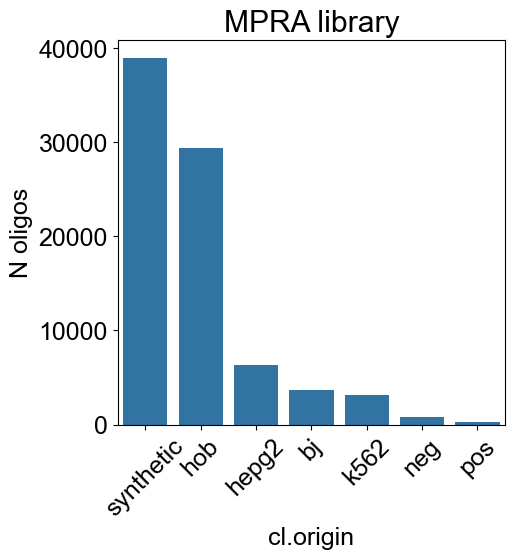

In [31]:
origins = df.groupby(["cl.origin"])["name"].count().reset_index().sort_values(by="name", ascending=False)
fig, ax=plt.subplots(figsize=(5,5))
sns.barplot(x="cl.origin", y="name", data=origins)
ax.set_xticklabels(ax.get_xticklabels(), 
                   rotation=45, 
                   #horizontalalignment="right"
                  )
ax.set(ylabel="N oligos", 
      title='MPRA library')
out = os.path.join(RE, "N_oligos.cl.origin.pdf")
plt.savefig(out, bbox_inches="tight")
origins

In [11]:
df.groupby(["cl.origin"])["name"].count()/df.groupby(["cl.origin", "exp"])["name"].count().sum()

cl.origin
bj           0.044353
hepg2        0.076322
hob          0.356033
k562         0.038677
neg          0.009217
pos          0.002644
synthetic    0.472754
Name: name, dtype: float64

# summarize by datatype

In [33]:
# summarize columns for legibility
df.loc[df["exp"].str.contains("deg"), "exp"] = 'deg'
df.loc[df["exp"].isin(["ilias", "vikram", "nondiff", "luc"]), "exp"] = 'other ctrl'

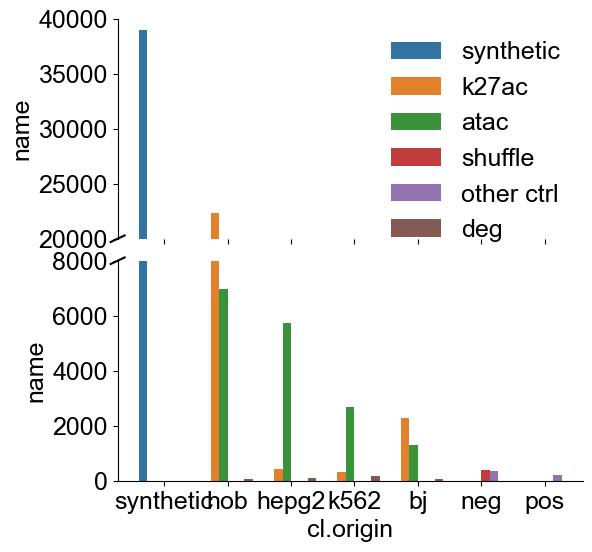

In [62]:
origins = df.groupby(["cl.origin", "exp"])["name"].count().reset_index().sort_values(by="name", ascending=False)
#fig, ax=plt.subplots(figsize=(5,5))
fig, (ax_top, ax_bottom) = plt.subplots(ncols=1, nrows=2, sharex=True, gridspec_kw={'hspace':0.1}, figsize=(6,6))
sns.barplot(x="cl.origin", y="name", data=origins, hue="exp", ax=ax_top)
sns.barplot(x="cl.origin", y="name", data=origins, hue="exp", ax=ax_bottom)

ax_top.set_ylim(20000, 40000)   # those limits are fake
ax_bottom.set_ylim(0,8000)

sns.despine(ax=ax_bottom)
sns.despine(ax=ax_top, bottom=True)

ax = ax_top
ax.legend(bbox_to_anchor = (1,1), frameon=False)
d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal

ax2 = ax_bottom
kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal

#remove one of the legend
ax_bottom.legend_.remove()


out = os.path.join(RE, "N_oligos.cl.origin.exp.pdf")
plt.savefig(out, bbox_inches="tight")
plt.show()

In [63]:
df.groupby(["cl.origin", "exp"])["name"].count()/df.groupby(["cl.origin", "exp"])["name"].count().sum()

cl.origin  exp       
bj         atac          0.015851
           deg           0.000776
           k27ac         0.027725
hepg2      atac          0.069725
           deg           0.001261
           k27ac         0.005336
hob        atac          0.084703
           deg           0.000582
           k27ac         0.270748
k562       atac          0.032382
           deg           0.002232
           k27ac         0.004063
neg        other ctrl    0.004366
           shuffle       0.004851
pos        other ctrl    0.002644
synthetic  synthetic     0.472754
Name: name, dtype: float64

In [65]:
df.groupby(["cl.origin", "exp"])["name"].count()

cl.origin  exp       
bj         atac           1307
           deg              64
           k27ac          2286
hepg2      atac           5749
           deg             104
           k27ac           440
hob        atac           6984
           deg              48
           k27ac         22324
k562       atac           2670
           deg             184
           k27ac           335
neg        other ctrl      360
           shuffle         400
pos        other ctrl      218
synthetic  synthetic     38980
Name: name, dtype: int64

In [67]:
df.groupby([ "exp"])["name"].count() , df.groupby([ "exp"])["name"].count()/df.groupby([ "exp"])["name"].count().sum()

(exp
 atac          16710
 deg             400
 k27ac         25385
 other ctrl      578
 shuffle         400
 synthetic     38980
 Name: name, dtype: int64,
 exp
 atac          0.202661
 deg           0.004851
 k27ac         0.307872
 other ctrl    0.007010
 shuffle       0.004851
 synthetic     0.472754
 Name: name, dtype: float64)